#<center>Assignment 3</center>

#Name: **Gopi Trinadh Maddikunta**
PSID: *2409404*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, GlobalAveragePooling1D, LSTM, SimpleRNN, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/nlp/assignment3_data.csv')

**Step 1: Preprocessing**

In [5]:
# Mapping sentiment labels explicitly
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['Sentiment'] = df['Sentiment'].map(sentiment_mapping)

# Preprocessing functions
def convert_numerical_values(sentence):
    def num_replacer(match):
        number = match.group()
        digit = sum([ord(c) for c in number if c.isdigit()]) % 9 + 1
        return str(digit)

    sentence = re.sub(r'\d+(\.\d+)?', num_replacer, sentence)
    return sentence

def convert_financial_terms(sentence):
    replacements = {'k': 'thousand', 'm': 'million', 'b': 'billion', 't': 'trillion'}

    def financial_replacer(match):
        currency, number, unit = match.group(1), match.group(2), match.group(3).lower()
        unit_full = replacements.get(unit, unit)
        return f"{number} {unit_full} {currency}".strip()

    pattern = re.compile(r'(USD|EUR|CAD)?\s?(\d+(?:\.\d+)?)([kmbtKMBT])')
    sentence = pattern.sub(financial_replacer, sentence)
    return sentence

def remove_punctuations(sentence):
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return sentence

def remove_extra_spaces(sentence):
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    return sentence

def preprocess_sentence(sentence):
    sentence = convert_financial_terms(sentence)
    sentence = convert_numerical_values(sentence)
    sentence = remove_punctuations(sentence)
    sentence = remove_extra_spaces(sentence)
    return sentence

# Apply preprocessing
df['Sentence'] = df['Sentence'].apply(preprocess_sentence)

# Final output
df_final = df[['Sentence', 'Sentiment']]

# Display sample output
print(df_final.head())

                                            Sentence  Sentiment
0  The GeoSolutions technology will leverage Bene...          2
1      ESI on lows down 7 to 8 BK a real possibility          0
2  For the last quarter of 7 Componenta s net sal...          2
3  According to the FinnishRussian Chamber of Com...          1
4  The Swedish buyout firm has sold its remaining...          1


In [ ]:
print(df_final.head(2))

                                            Sentence  Sentiment
0  The GeoSolutions technology will leverage Bene...          2
1      ESI on lows down 7 to 8 BK a real possibility          0


#**Step 2: Creating an embedding matrix**

In [6]:
# Load pretrained Word2Vec embeddings
word2vec_model = api.load('word2vec-google-news-300')

# Tokenize sentences
tokenizer = Tokenizer(oov_token=None, filters='', lower=False)
tokenizer.fit_on_texts(df_final['Sentence'])

# Build vocabulary of words that exist in Word2Vec
word_index = {'</s>': 0}  # You can use <s> for start token if needed
embedding_dim = 300

for word in tokenizer.word_index:
    if word in word2vec_model:
        word_index[word] = len(word_index)

# Prepare embedding matrix
vocab_size = len(word_index)
embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype=np.float32)

for word, idx in word_index.items():
    if word != '</s>' and word in word2vec_model:
        embedding_vector = word2vec_model[word]
        embedding_matrix[idx] = np.array(embedding_vector, dtype=np.float32)

# Convert sentences to sequences of indices
sequences = []
for sentence in df_final['Sentence']:
    seq = [word_index[word] for word in sentence.split() if word in word_index]
    sequences.append(seq)

# Determine max sequence length and pad with zeros (pre-padding)
max_seq_length = max(len(seq) for seq in sequences) + 2
X = pad_sequences(sequences, maxlen=max_seq_length, padding='pre')

# Convert sentiment labels to one-hot encoding
num_classes = len(df_final['Sentiment'].unique())
y = to_categorical(df_final['Sentiment'], num_classes=num_classes)

# Output shapes
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Embedding matrix shape:", embedding_matrix.shape)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Shape of X: (5842, 50)
Shape of y: (5842, 3)
Embedding matrix shape: (10908, 300)


# **Step 3: Neural Networks**

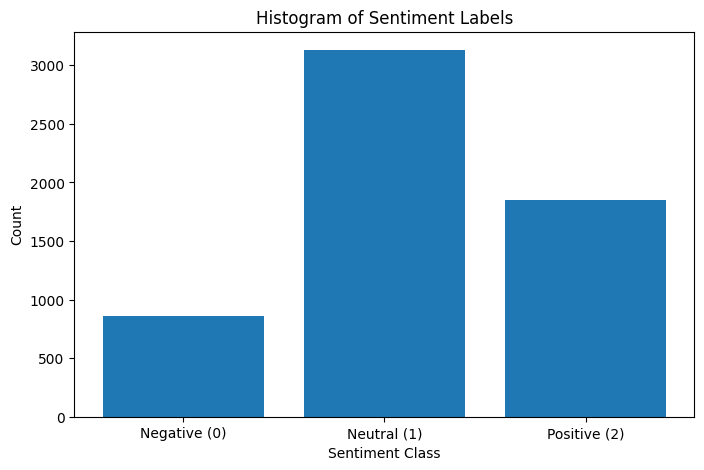

Label counts: [ 860. 3130. 1852.]
Imbalance Ratio: 3.64

Class imbalance detected.
Using class_weights to balance training and prevent bias toward the majority class.
Class Weights used in training: {0: 2.264341085271318, 1: 0.6221512247071352, 2: 1.0514758819294456}


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical

# Assume y is one-hot encoded
label_counts = np.sum(y, axis=0)

# Plotting histogram of labels
plt.figure(figsize=(8, 5))
plt.bar(['Negative (0)', 'Neutral (1)', 'Positive (2)'], label_counts)
plt.title('Histogram of Sentiment Labels')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.show()

# Imbalance check
max_count = np.max(label_counts)
min_count = np.min(label_counts)
imbalance_ratio = max_count / min_count

print("Label counts:", label_counts)
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    print("\nClass imbalance detected.")
    print("Using class_weights to balance training and prevent bias toward the majority class.")

    # Convert one-hot to class integers
    y_int = np.argmax(y, axis=1)

    # Compute balanced class weights
    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(y_int),
                                         y=y_int)

    # Convert to dictionary for Keras
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
    print("Class Weights used in training:", class_weights_dict)

else:
    print("\nNo significant class imbalance detected.")
    print("Model training will proceed without class weights.")
    class_weights_dict = None


In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5)
]

In [10]:
def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

###: **1- FFN Classifier with pre-trained embeddings:**

Epoch 1/50
132/132 [==============================] - 6s 31ms/step - loss: 0.9183 - accuracy: 0.5817 - val_loss: 0.8532 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 4s 31ms/step - loss: 0.7145 - accuracy: 0.6866 - val_loss: 0.8179 - val_accuracy: 0.6474 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 5s 37ms/step - loss: 0.5784 - accuracy: 0.7643 - val_loss: 0.8136 - val_accuracy: 0.6282 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 4s 28ms/step - loss: 0.4710 - accuracy: 0.8083 - val_loss: 0.8635 - val_accuracy: 0.6068 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 4s 28ms/step - loss: 0.3860 - accuracy: 0.8416 - val_loss: 0.9440 - val_accuracy: 0.6282 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 5s 34ms/step - loss: 0.3226 - accuracy: 0.8659 - val_loss: 1.0352 - val_accuracy: 0.6239 - lr: 0.0010
Epoch 7/50
132/132 [==============================] - 8s 60ms/st

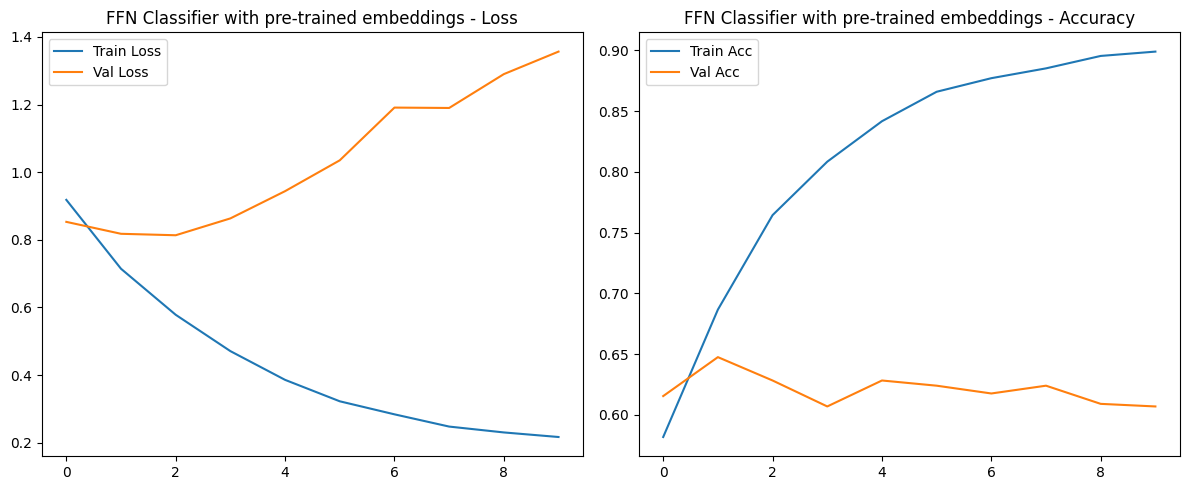

37/37 [==============================] - 0s 6ms/step
FFN Classifier with pre-trained embeddings Report:
               precision    recall  f1-score   support

           0       0.34      0.21      0.26       175
           1       0.70      0.82      0.76       622
           2       0.63      0.58      0.60       372

    accuracy                           0.65      1169
   macro avg       0.56      0.54      0.54      1169
weighted avg       0.63      0.65      0.63      1169



In [11]:
# --------------------- FFN Classifier with pre-trained embeddings ---------------------
model1 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_seq_length, weights=[embedding_matrix], trainable=False),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=callbacks, verbose=1)
model1.summary()
plot_history(history1, "FFN Classifier with pre-trained embeddings")
y_pred = model1.predict(X_test)
print("FFN Classifier with pre-trained embeddings Report:\n", classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

### **2- [FFN Classifier with fine-tuning pre-trained embeddings](https://)**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 300)           3272400   
                                                                 
 flatten_1 (Flatten)         (None, 15000)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               1920128   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                

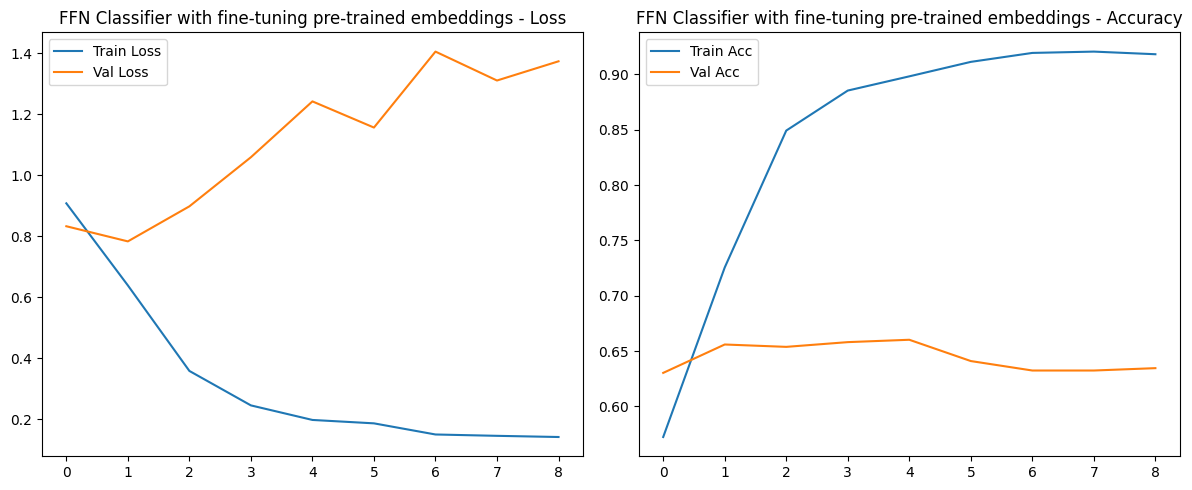

37/37 [==============================] - 0s 5ms/step
FFN Classifier with fine-tuning pre-trained embeddings Report:
               precision    recall  f1-score   support

           0       0.26      0.06      0.09       175
           1       0.72      0.83      0.77       622
           2       0.62      0.69      0.65       372

    accuracy                           0.67      1169
   macro avg       0.53      0.52      0.51      1169
weighted avg       0.62      0.67      0.63      1169



In [12]:
# --------------------- FFN Classifier with fine-tuning pre-trained embeddings ---------------------
model2 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_seq_length, weights=[embedding_matrix], trainable=True),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=callbacks, verbose=0)
model2.summary()
plot_history(history2, "FFN Classifier with fine-tuning pre-trained embeddings")
y_pred = model2.predict(X_test)
print("FFN Classifier with fine-tuning pre-trained embeddings Report:\n", classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

###**3- RNN with FFN Classifier head and using pre-trained embeddings**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 300)           3272400   
                                                                 
 lstm (LSTM)                 (None, 50, 128)           219648    
                                                                 
 dropout_4 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)               

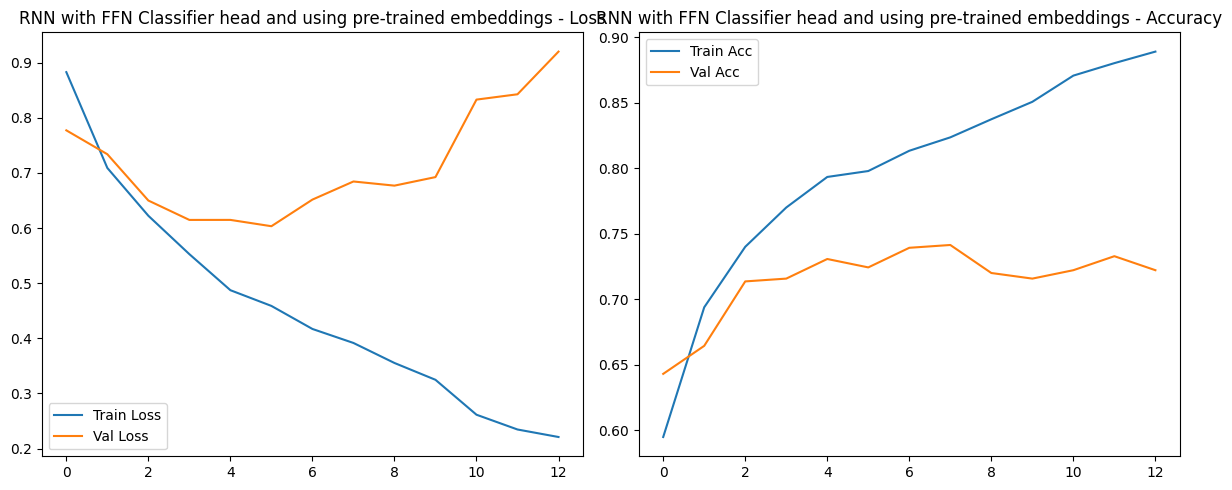

37/37 [==============================] - 3s 57ms/step
RNN with FFN Classifier head and using pre-trained embeddings Report:
               precision    recall  f1-score   support

           0       0.50      0.30      0.38       175
           1       0.80      0.79      0.79       622
           2       0.69      0.83      0.76       372

    accuracy                           0.73      1169
   macro avg       0.67      0.64      0.64      1169
weighted avg       0.72      0.73      0.72      1169



In [13]:
# --------------------- RNN with FFN Classifier head and using pre-trained embeddings ---------------------
model3 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_seq_length, weights=[embedding_matrix], trainable=False),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history3 = model3.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=callbacks, verbose=0)
model3.summary()
plot_history(history3, "RNN with FFN Classifier head and using pre-trained embeddings")
y_pred = model3.predict(X_test)
print("RNN with FFN Classifier head and using pre-trained embeddings Report:\n", classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

###**4- complex RNN with FFN Classifier head using pre-trained embeddings**

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 300)           3272400   
                                                                 
 bidirectional (Bidirection  (None, 50, 256)           109824    
 al)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               41088     
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)               

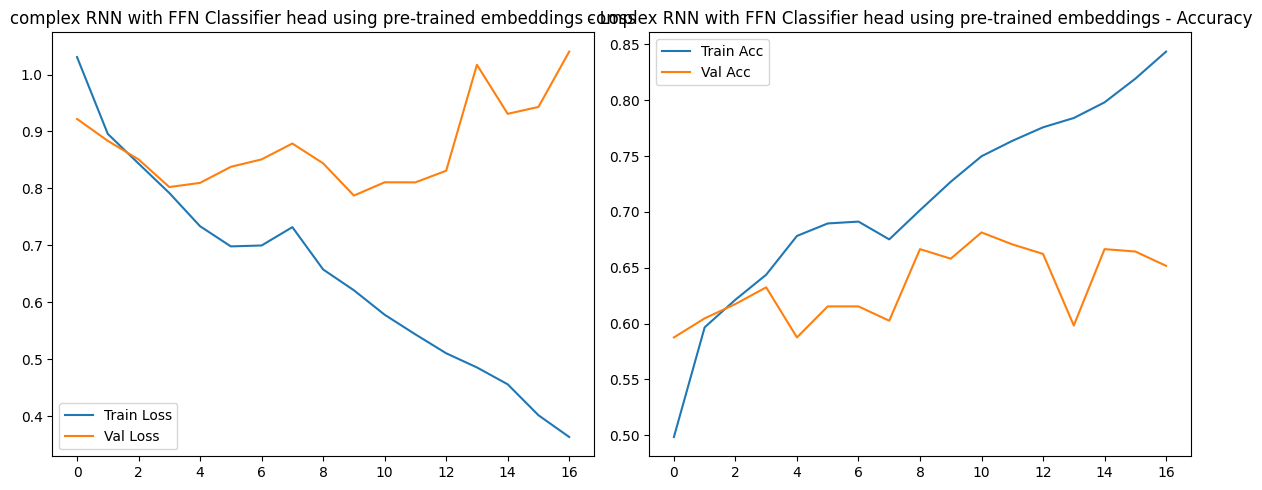

37/37 [==============================] - 1s 21ms/step
complex RNN with FFN Classifier head using pre-trained embeddings Report:
               precision    recall  f1-score   support

           0       0.47      0.23      0.31       175
           1       0.73      0.78      0.76       622
           2       0.61      0.69      0.65       372

    accuracy                           0.67      1169
   macro avg       0.60      0.57      0.57      1169
weighted avg       0.66      0.67      0.66      1169



In [14]:
# --------------------- complex RNN with FFN Classifier head using pre-trained embeddings ---------------------
model4 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_seq_length, weights=[embedding_matrix], trainable=False),
    Bidirectional(SimpleRNN(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(SimpleRNN(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history4 = model4.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=callbacks, verbose=0)
model4.summary()
plot_history(history4, "complex RNN with FFN Classifier head using pre-trained embeddings")
y_pred = model4.predict(X_test)
print("complex RNN with FFN Classifier head using pre-trained embeddings Report:\n", classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

### **5- RNN using LSTMs with FFN Classifier head using pre-trained embeddings**

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 300)           3272400   
                                                                 
 lstm_2 (LSTM)               (None, 50, 128)           219648    
                                                                 
 dropout_10 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50, 64)            49408     
                                                                 
 dropout_11 (Dropout)        (None, 50, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_12 (Dropout)        (None, 32)               

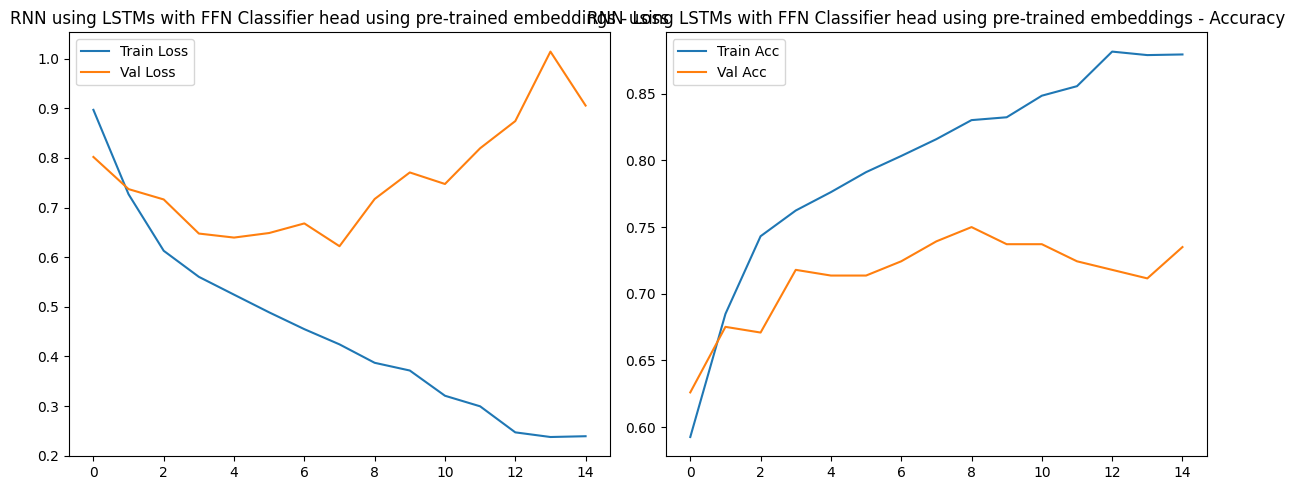

37/37 [==============================] - 3s 47ms/step
RNN using LSTMs with FFN Classifier head using pre-trained embeddings Report:
               precision    recall  f1-score   support

           0       0.49      0.46      0.47       175
           1       0.82      0.77      0.79       622
           2       0.71      0.81      0.76       372

    accuracy                           0.74      1169
   macro avg       0.67      0.68      0.68      1169
weighted avg       0.74      0.74      0.73      1169



In [15]:
# --------------------- RNN using LSTMs with FFN Classifier head using pre-trained embeddings ---------------------
model5 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_seq_length, weights=[embedding_matrix], trainable=False),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64, return_sequences=True),
    Dropout(0.4),
    LSTM(32),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history5 = model5.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=callbacks, verbose=0)
model5.summary()
plot_history(history5, "RNN using LSTMs with FFN Classifier head using pre-trained embeddings")
y_pred = model5.predict(X_test)
print("RNN using LSTMs with FFN Classifier head using pre-trained embeddings Report:\n", classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))


###**6- RNN using Bi-LSTMs with FFN Classifier head using pre-trained embeddings**

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 300)           3272400   
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 256)           439296    
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 50, 128)           164352    
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 50, 128)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)               

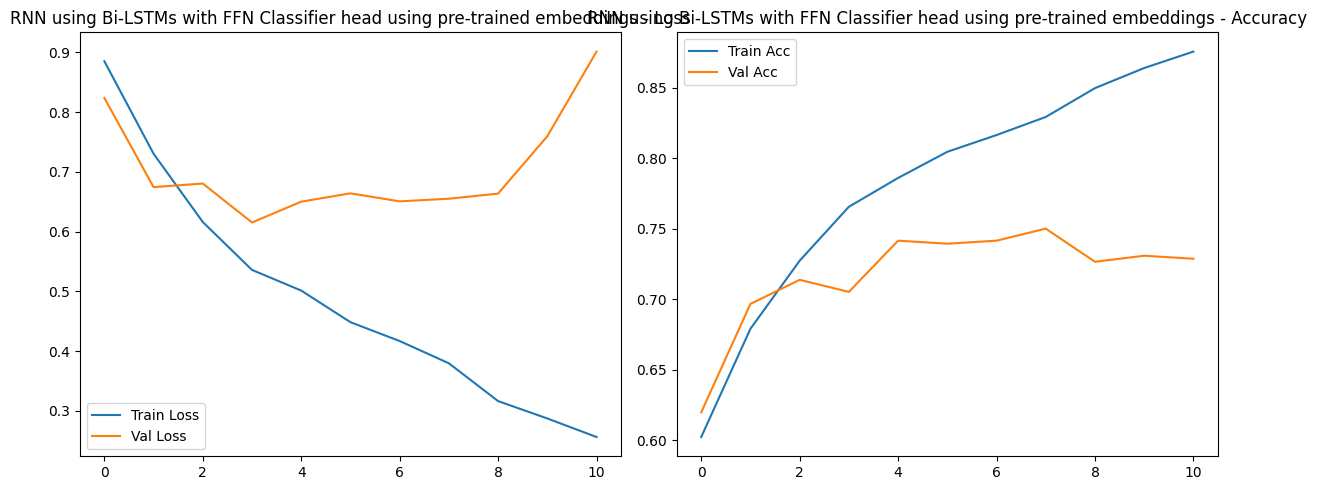

37/37 [==============================] - 8s 132ms/step
RNN using Bi-LSTMs with FFN Classifier head using pre-trained embeddings Report:
               precision    recall  f1-score   support

           0       0.56      0.39      0.46       175
           1       0.78      0.89      0.83       622
           2       0.79      0.71      0.75       372

    accuracy                           0.76      1169
   macro avg       0.71      0.67      0.68      1169
weighted avg       0.75      0.76      0.75      1169



In [16]:
# --------------------- RNN using Bi-LSTMs with FFN Classifier head using pre-trained embeddings ---------------------
model6 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_seq_length, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history6 = model6.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=callbacks, verbose=0)
model6.summary()
plot_history(history6, "RNN using Bi-LSTMs with FFN Classifier head using pre-trained embeddings")
y_pred = model6.predict(X_test)
print("RNN using Bi-LSTMs with FFN Classifier head using pre-trained embeddings Report:\n", classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

###**choosed classifier: BiLSTM Fine-Tuned Embedding Classifier**

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 300)           3272400   
                                                                 
 bidirectional_5 (Bidirecti  (None, 50, 256)           439296    
 onal)                                                           
                                                                 
 batch_normalization (Batch  (None, 50, 256)           1024      
 Normalization)                                                  
                                                                 
 dropout_18 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_6 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                      

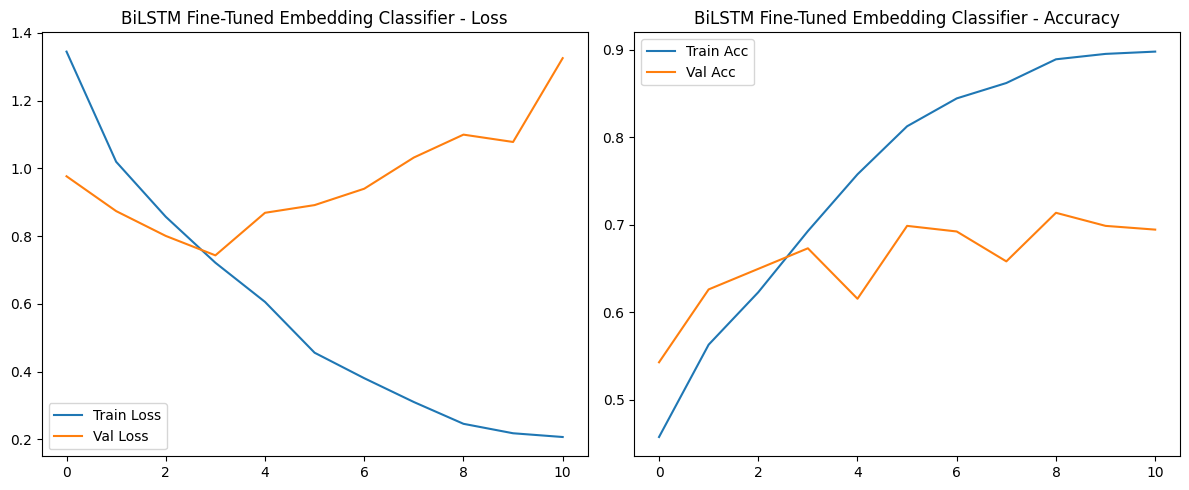

37/37 [==============================] - 6s 104ms/step
BiLSTM Fine-Tuned Embedding Classifier Report:
               precision    recall  f1-score   support

           0       0.43      0.02      0.03       175
           1       0.71      0.84      0.77       622
           2       0.62      0.71      0.66       372

    accuracy                           0.67      1169
   macro avg       0.59      0.52      0.49      1169
weighted avg       0.64      0.67      0.62      1169



In [17]:
# --------------------- BiLSTM Fine-Tuned Embedding Classifier ---------------------
model7 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_seq_length, weights=[embedding_matrix], trainable=True),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history7 = model7.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=callbacks, verbose=0)
model7.summary()
plot_history(history7, "BiLSTM Fine-Tuned Embedding Classifier")
y_pred = model7.predict(X_test)
print("BiLSTM Fine-Tuned Embedding Classifier Report:\n", classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

### Draw a conclusion on models 3, 4, 5, and 6. Which one performed better overall?

In [21]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import pandas as pd

# Example y_true and predictions
y_true = np.argmax(y_test, axis=1)  # If your y_test is one-hot
# y_pred3, y_pred4, y_pred5, y_pred6 must be already defined

model_metrics = {}

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')

    model_metrics[name] = {
        'Accuracy': round(acc, 4),
        'Macro F1': round(macro_f1, 4),
        'Weighted F1': round(weighted_f1, 4)
    }

# Evaluate your models
evaluate_model("Model 3 - LSTM", y_true, np.argmax(y_pred3, axis=1))
evaluate_model("Model 4 - Bi-SimpleRNN", y_true, np.argmax(y_pred4, axis=1))
evaluate_model("Model 5 - Deep LSTM", y_true, np.argmax(y_pred5, axis=1))
evaluate_model("Model 6 - Stacked Bi-LSTM", y_true, np.argmax(y_pred6, axis=1))

# Display results
df_results = pd.DataFrame(model_metrics).T.sort_values(by='Macro F1', ascending=False)
print(df_results)


                           Accuracy  Macro F1  Weighted F1
Model 6 - Stacked Bi-LSTM    0.7588    0.6804       0.7494
Model 5 - Deep LSTM          0.7357    0.6754       0.7348
Model 3 - LSTM               0.7314    0.6432       0.7202
Model 4 - Bi-SimpleRNN       0.6707    0.5709       0.6557


<Figure size 1200x600 with 0 Axes>

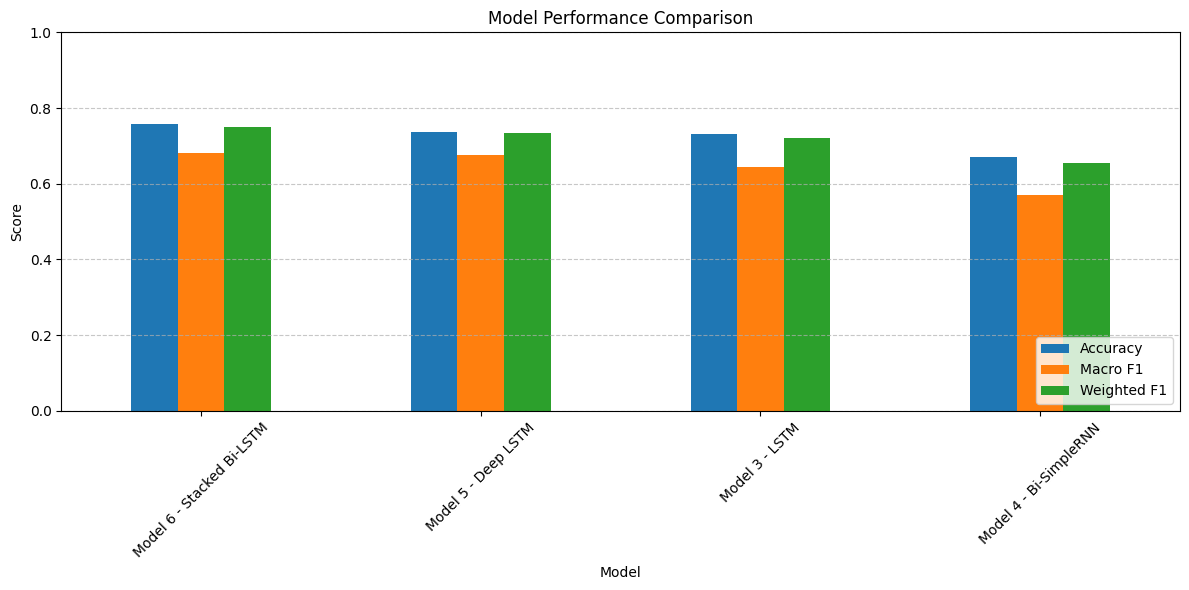

In [22]:
import matplotlib.pyplot as plt

# Optional: If you haven't already, make sure df_results exists
# df_results = pd.DataFrame(model_metrics).T.sort_values(by='Macro F1', ascending=False)

# Plot Accuracy, Macro F1, and Weighted F1 for each model
plt.figure(figsize=(12, 6))
df_results.plot(kind='bar', figsize=(12, 6))

plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


###Check to see if your vocabulary has repeated words with different cases (e.g. The and the). Why do we have them both? Find 4 more examples of this and report here.

In [23]:
# Assume 'word_index' is your vocabulary dictionary (e.g., from tokenizer)
from collections import defaultdict

# Group words by their lowercase form
case_variants = defaultdict(list)

for word in word_index:
    lower = word.lower()
    case_variants[lower].append(word)

# Find and print only 5 entries that have more than one casing variant
print("Case-sensitive duplicates found in vocabulary (showing 5):\n")
count = 0
for lower, variants in case_variants.items():
    if len(variants) > 1:
        print(f"{variants}")
        count += 1
        if count == 5:
            break


Case-sensitive duplicates found in vocabulary (showing 5):

['the', 'The', 'THE']
['in', 'In', 'IN']
['for', 'For', 'FOR']
['EUR', 'eur']
['s', 'S']


###Check Word2Vec embeddings. Are word embeddings (from Word2Vec) similar for these words or are they different? Why?

In [24]:
from gensim.models import KeyedVectors
from gensim import downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np



# Example word pairs
word_pairs = [('Bank', 'bank'), ('US', 'us'), ('Profit', 'profit'), ('The', 'the'), ('CEO', 'Ceo')]

print("Cosine similarity between word pairs:\n")
for w1, w2 in word_pairs:
    if w1 in word2vec_model and w2 in word2vec_model:
        vec1 = word2vec_model[w1].reshape(1, -1)
        vec2 = word2vec_model[w2].reshape(1, -1)
        similarity = cosine_similarity(vec1, vec2)[0][0]
        print(f"{w1} vs {w2}: {similarity:.4f}")
    else:
        print(f"One or both words not found: {w1}, {w2}")


Cosine similarity between word pairs:

Bank vs bank: 0.6699
US vs us: 0.0594
Profit vs profit: 0.6339
The vs the: 0.4477
CEO vs Ceo: 0.5719


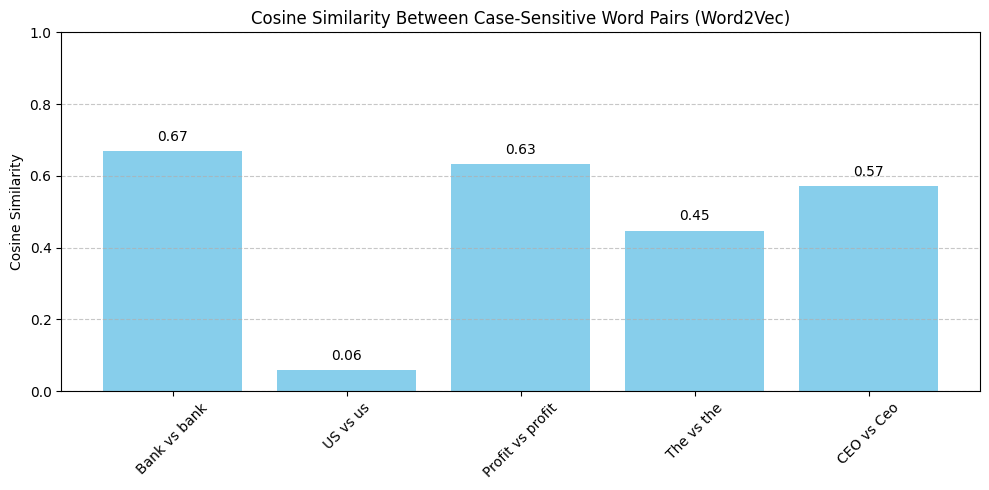

In [25]:
from gensim import downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np



# List of word pairs to compare
word_pairs = [('Bank', 'bank'), ('US', 'us'), ('Profit', 'profit'), ('The', 'the'), ('CEO', 'Ceo')]

# Store similarity scores
similarities = []
labels = []

for w1, w2 in word_pairs:
    if w1 in word2vec_model and w2 in word2vec_model:
        vec1 = word2vec_model[w1].reshape(1, -1)
        vec2 = word2vec_model[w2].reshape(1, -1)
        sim = cosine_similarity(vec1, vec2)[0][0]
        similarities.append(sim)
        labels.append(f"{w1} vs {w2}")
    else:
        similarities.append(0)
        labels.append(f"{w1} vs {w2} (OOV)")

# Plotting
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, similarities, color='skyblue')
plt.title('Cosine Similarity Between Case-Sensitive Word Pairs (Word2Vec)')
plt.ylabel('Cosine Similarity')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
